#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import time

In [2]:
df = pd.read_csv("/datasets/taxi.csv",parse_dates =[0],index_col= 0)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df = df.sort_index()

In [5]:
df.index.is_monotonic

True

In [6]:
df = df.resample("1H").sum()

In [7]:
df_new = df.copy()
final_df = df.copy()

#### Выводы 

Заметив, что наши данные с периодичностью 10 минут, мы их ресемплировали.   
Cоздали 2 переменные для анализа и для создания корректных признаков данных.

## Анализ

Найдем скользящее стандартное отклонение — стандартное отклонение по скользящему окну, и посмотрим на стационарность ряда.

In [8]:
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

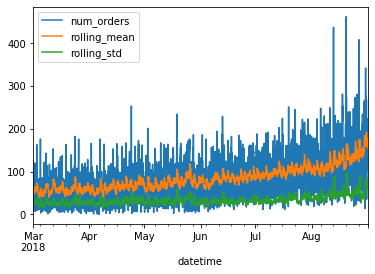

In [14]:
df.plot()

Видим, что временные ряды достаточно стационарны. Посмотрим, как изменится ситуация, если произвести разность ряда. 

In [15]:
df_new = df - df.shift()

In [16]:
df_new["rolling_mean"] = df_new["num_orders"].rolling(20).mean()
df_new["rolling_std"] = df_new["num_orders"].rolling(20).std()

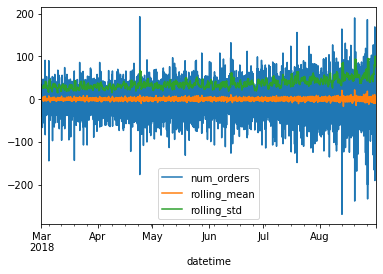

In [17]:
df_new.plot()

In [19]:
df_new.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675


Видим, что среднее значение временного ряда практически не меняется. Наш ряд стационарный, а значит прогнозировать его будет намного легче, так как не будет слишком быстро меняющихся свойств. 

Напишем функцию make_features(), чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели. Но будем работать на второй переменной, которая не использовалась для анализа. 

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(final_df,24,20)

Построим графики тренда и сезонности (по часам)

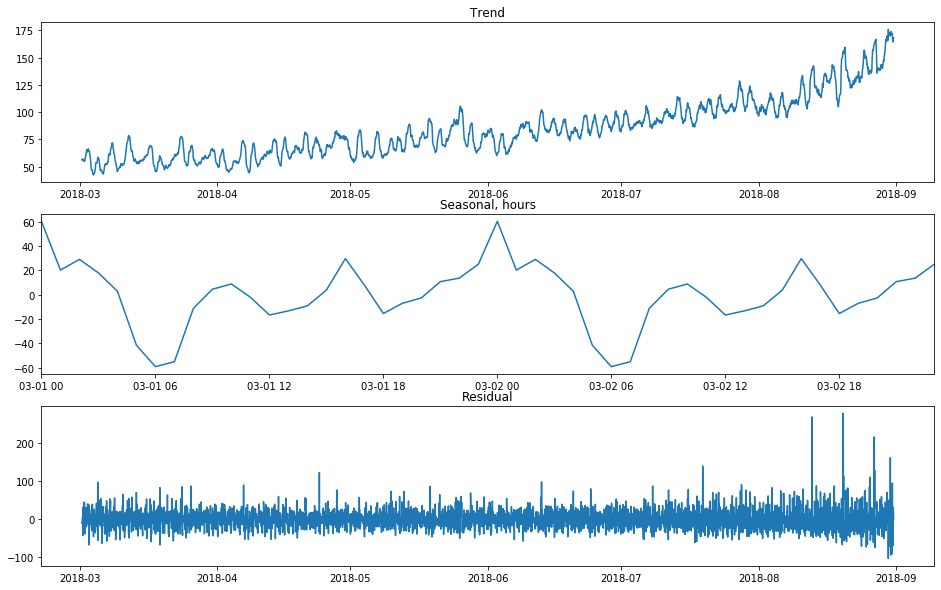

In [25]:
decomposed = seasonal_decompose(final_df["num_orders"]) 

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, hours")
axs[1].set_xlim(('2018-03-01 00:00:00','2018-03-02 23:00:00'))

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

#### Выводы 

Мы выяснили, что наш ряд стационарный и что он будет эффективнее в прогнозировании количества заказов такси в последующий час. 
Использовали вторую переменную final_df для добавления новых календарных признаков к таблице.  
Построили графики тренда и сезонности и увидели, что рост заказов такси прихоодится ближе к вечеру, ночи (00:00:00).  
Данные проанализированы и почти готовы к обучению. Перейдем к созданию призаков.

## Обучение

Разделим данные на тренировочную и тестовую выборки. Сделаем тестовую выборку размером 10% от исходных данных.

In [26]:
train,test = train_test_split(final_df,shuffle = False, random_state = 42, test_size = 0.1)

In [27]:
train = train.dropna()

In [28]:
(train_features, test_features) = (train.drop('num_orders',axis = 1), test.drop('num_orders',axis = 1))
(train_target, test_target) = (train['num_orders'], test['num_orders'])

Для обучения мы выбрали три разные модели: CatBoostRegressor, LightGBM и Линейную Регрессию. Посмотрим, какая модель быстрее и точнее прогнозирует.

In [36]:
splits = TimeSeriesSplit(n_splits=3)

**CatBoostRegressor**

In [37]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)

0:	loss: 33.1754143	best: 33.1754143 (0)	total: 22.1s	remaining: 3m 19s
1:	loss: 34.4560748	best: 33.1754143 (0)	total: 40.4s	remaining: 2m 41s
2:	loss: 33.5884733	best: 33.1754143 (0)	total: 1m 5s	remaining: 2m 31s
3:	loss: 35.9408523	best: 33.1754143 (0)	total: 1m 35s	remaining: 2m 23s
4:	loss: 34.0182325	best: 33.1754143 (0)	total: 2m 3s	remaining: 2m 3s
5:	loss: 37.1099013	best: 33.1754143 (0)	total: 4m 36s	remaining: 3m 4s
6:	loss: 37.6999612	best: 33.1754143 (0)	total: 7m 10s	remaining: 3m 4s
7:	loss: 39.7057495	best: 33.1754143 (0)	total: 9m 45s	remaining: 2m 26s
8:	loss: 38.9080718	best: 33.1754143 (0)	total: 12m 19s	remaining: 1m 22s
9:	loss: 39.9738337	best: 33.1754143 (0)	total: 14m 56s	remaining: 0us
Estimating final quality...


In [38]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 36.9684097	total: 2.61ms	remaining: 2.61s
100:	learn: 21.2410502	total: 2.97s	remaining: 26.4s
200:	learn: 18.2972547	total: 5.83s	remaining: 23.2s
300:	learn: 16.4140357	total: 7.99s	remaining: 18.6s
400:	learn: 14.9079211	total: 10s	remaining: 15s
500:	learn: 13.5906451	total: 12.2s	remaining: 12.2s
600:	learn: 12.4677805	total: 14.2s	remaining: 9.41s
700:	learn: 11.4108071	total: 16.3s	remaining: 6.96s
800:	learn: 10.4940732	total: 18.4s	remaining: 4.57s
900:	learn: 9.6595782	total: 20.4s	remaining: 2.25s
999:	learn: 8.9679636	total: 22.4s	remaining: 0us
CPU times: user 20 s, sys: 2.89 s, total: 22.9 s
Wall time: 28.8 s


In [39]:
preds_Cat_train = final_cat.predict(train_features)
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5
RMSE_CatBoost_train

**LinearRegression**

In [46]:
%%time
LR = LinearRegression()
LR.fit(train_features, train_target)
preds_LR_train = LR.predict(train_features)
RMSE_LR_train = (mean_squared_error(train_target,preds_LR_train))**0.5
RMSE_LR_train

25.84786526854025

**LightGBM**

In [47]:
%%time
lgb_train = lgb.Dataset(train_features,train_target)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light, lgb_train, num_boost_round=1000, verbose_eval=100)

In [49]:
preds_Light_train = light.predict(train_features)
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5
RMSE_LightGBM_train

0.609075883499272

#### Выводы 

Модели обучены, перейдем к тестированию.

## Тестирование

In [50]:
# CatBoost
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

#LightGBM
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(test_features)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

#Линейная регрессия 
LR_test_start_time=time.time()
preds_LR_test=LR.predict(test_features)
LR_test_total_time = time.time() - LR_test_start_time

In [51]:
RMSE_CatBoost_test = (mean_squared_error(test_target,preds_Cat_test))**0.5

RMSE_LightGBM_test = (mean_squared_error(test_target,preds_Light_test))**0.5

RMSE_LR_test = (mean_squared_error(test_target,preds_LR_test))**0.5

In [52]:
report = pd.DataFrame(columns = ["CatBoost","LightGBM", 'LinReg'],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               "Время предсказания (секунды)"])


report.iloc[0] = [RMSE_CatBoost_train,RMSE_LightGBM_train, RMSE_LR_train]
report.iloc[1] = [RMSE_CatBoost_test,RMSE_LightGBM_test, RMSE_LR_test]
report.iloc[2] = [CatBoost_test_total_time,LightGBM_test_total_time, LR_test_total_time]

In [53]:
report

,CatBoost,LightGBM,LinReg
RMSE(train),8.96796,0.609076,25.8479
RMSE(test),40.9126,41.6169,45.1737
Время предсказания (секунды),0.0211535,0.0393796,0.00985789


#### Выводы 

Заказчик обозначил, чтобы значение метрики RMSE на тестовой выборке должно быть не больше 48. Все три модели выполняют это условие, но модель CatBoost показала наилучший результат. Модель Линейной Регрессии же выполняет условие по необходимому значению метрики RMSE и по самому быстрому времени предсказания.